# Download data and install necessary dependencies

In [1]:
!curl -Lo /content/competitors_reddit.csv https://lp-prod-resources.s3.amazonaws.com/757/76346/2021-10-12-00-21-08/competitors_reddit.csv
!pip install install pytorch>=1.6 cudatoolkit=11.0 -c pytorch
!pip install simpletransformers
!pip install wandb
!pip install transformers

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4537k  100 4537k    0     0  2227k      0  0:00:02  0:00:02 --:--:-- 2228k
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'pytorch'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 112.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.3 MB/s eta 

# Import Dependencies

In [2]:
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from simpletransformers.t5 import T5Model
import sklearn
import wandb
from transformers import T5Tokenizer, T5ForConditionalGeneration


# Set wandb api key

In [3]:
%env WANDB_API_KEY={"8fed25a36c785fb869426ffff16b98259a4ecec3"}

env: WANDB_API_KEY=8fed25a36c785fb869426ffff16b98259a4ecec3


# Data Preprocessing

In [4]:
# read data
data = pd.read_csv("/content/competitors_reddit.csv")
data.head(1)

,index,submission_id,submission_title,submission_link_flair_text,submission_selftext,reply_body
0,0,f96vya,New versions of A5 and A6 Agile firmwares are ...,NaN,"Dear Supernote users, new versions of A5 and A...","[""There was video of a multifunction button to..."


**What is literal_eval in Python?**

literal_eval() method is a useful tool for processing data that is stored in a string format

In [5]:
reply_body_str_list = [ast.literal_eval(sent) for sent in data["reply_body"]]

create input_text by combining submission_selftext and reply_body

In [6]:
data["input_text"] = data["submission_selftext"] + " " + data["reply_body"]

Create target_text from submission_title

In [7]:
data["target_text"] = data["submission_title"]

In [8]:
data["submission_title"].shape

(1974,)

In [9]:
data.shape

(1974, 8)

filter data by removing all nan values

In [10]:
new_df = data[data["input_text"].isna() == False]

In [11]:
new_df.shape

(1608, 8)

check if any null is present or not

In [12]:
new_df[new_df["input_text"].isna() == True]

,index,submission_id,submission_title,submission_link_flair_text,submission_selftext,reply_body,input_text,target_text


convert data into list for model training

In [13]:
X = list(new_df["input_text"])
Y = list(new_df["target_text"])
train_tag, val_tag, train_tag_label, val_tag_label = train_test_split(X, Y, test_size = 0.1)

In [14]:
category_train = ['title prediction']*len(train_tag_label)
# category_train

In [15]:
category_val = ['title prediction']*len(val_tag_label)
# category_val

In [16]:
print(len(category_train), len(train_tag), len(train_tag_label))

1447 1447 1447


This is the format :

**prefix :**  A string indicating the task to perform.

**input_text :** The input text sequence. prefix is automatically prepended to form the full input.

**target_text :** The target sequence

In [17]:
train_tag_df = pd.DataFrame({
    "prefix" : category_train,
    "input_text" : train_tag,
    "target_text" : train_tag_label
})

In [18]:
print(train_tag_df.shape)
print(train_tag_df.head(1))

(1447, 3)
             prefix                                         input_text  \
0  title prediction  Is anyone else having trouble completing the p...   

                       target_text  
0  A5X Preorder doesn't go through  


In [19]:
val_tag_df = pd.DataFrame({
    "prefix" : category_val,
    "input_text" : val_tag,
    "target_text" : val_tag_label
})

In [20]:
print(val_tag_df.shape)
print(val_tag_df.head(1))

(161, 3)
             prefix                                         input_text  \
0  title prediction  My supernote arrived today, and I have been pl...   

                           target_text  
0  Insert margin on note export to PDF  


concatenate data with upsampled data

In [21]:
train_data = pd.read_csv("/content/singletask_train.csv").astype(str)
val_data = pd.read_csv("/content/singlatask_noupsampling_val.csv").astype(str)

# train_data.rename(columns = {'category_train':'prefix'}, inplace = True)
# val_data.rename(columns = {'category_val':'prefix'}, inplace = True)

combined_train_data = pd.concat([train_data, train_tag_df], axis=0)
combined_val_data = pd.concat([val_data, val_tag_df], axis=0)

In [22]:
combined_train_data.head()

,prefix,input_text,target_text
0,tag classification,nan,Review
1,tag classification,nan,Review
2,tag classification,nan,Question
3,tag classification,nan,Question
4,tag classification,Added an A3 template but it’s added as A4 in m...,Question


In [23]:
combined_train_data.shape

(1755, 3)

here we filter again by removing all nan values in train and val data

In [24]:
combined_train_data = combined_train_data[combined_train_data["input_text"] != "nan"]

In [25]:
combined_train_data.shape

(1618, 3)

In [26]:
combined_val_data.shape

(210, 3)

In [27]:
combined_val_data = combined_val_data[combined_val_data["input_text"] != "nan"]

In [28]:
combined_val_data.shape

(193, 3)

# Model Training

This function takes input as Dataframe(train and validation data) that must be in required format and your wandb project name

In [29]:
def train_model(train_df, eval_df, wandb_name):
  model_args = {
      "output_dir" : "/content/",
      "max_seq_length": 400,
      "train_batch_size": 2,
      "eval_batch_size": 2,
      "num_train_epochs": 1,
      "evaluate_during_training": True,
      "evaluate_during_training_steps": 15000,
      "evaluate_during_training_verbose": True,
      "use_multiprocessing": False,
      "fp16": True,
      "save_steps": 30,
      "save_eval_checkpoints": False,
      "save_model_every_epoch": False,
      "reprocess_input_data": True,
      "overwrite_output_dir": True,
      "wandb_project": wandb_name,
      "scheduler": "polynomial_decay_schedule_with_warmup",

  }
  model = T5Model('t5', 't5-base', use_cuda=True, cuda_device=0, args=model_args)
  model.train_model(train_df, eval_data=eval_df)
  return model

In [30]:
train_model(combined_train_data, combined_val_data, "T5 - Single Task")

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the

  0%|          | 0/1618 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

wandb: Currently logged in as: huzaifa-ali. Use `wandb login --relogin` to force relogin


Running Epoch 0 of 1:   0%|          | 0/809 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/193 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [31]:
wandb.finish()

Training loss,▅▅▂█▅▃▄▃▂▂▂▁▂▄▄▁
eval_loss,▁
global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇▇██
lr,██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train_loss,▁
Training loss,0.04036
eval_loss,0.07782
global_step,809
lr,1e-05
train_loss,0.14683


In [32]:
training_progress_scores_model1 = pd.read_csv("/content/training_progress_scores.csv")
training_progress_scores_model1.tail()

,global_step,eval_loss,train_loss
0,809,0.077815,0.146832


# Model Performance

This function takes validataion data as input and returns classification reports and confusion matrix

In [33]:
def get_model_performance(eval_data):
  model_args_performance = {
      "overwrite_output_dir": True,
      "max_seq_length": 400,
      "eval_batch_size": 4,
      "use_multiprocessing": False,
      "num_beams": 5,
      "do_sample": True,
      "max_length": 10,
      "top_k": 50,
      "top_p": 0.95,
      "num_return_sequences": 2,
  }
  model = T5Model("t5", "/content/outputs/best_model", args=model_args_performance)
  # Load the evaluation data
  eval_df = pd.read_csv(eval_data).astype(str)
  # Prepare the data for testing
  to_predict = [
      prefix + ": " + str(input_text)
      for prefix, input_text in zip(eval_df["prefix"].tolist(), eval_df["input_text"].tolist())
  ]
  truth = eval_df["target_text"].tolist()
  tasks = eval_df["prefix"].tolist()

  # Get the model predictions
  preds = model.predict(to_predict)
  prediction_labels = []
  for pred in preds:
    pred = pred[0].strip()
    prediction_labels.append(pred)

  val_labels = eval_df["target_text"]
  result = model.eval_model(eval_df, f1 = sklearn.metrics.f1_score, acc = sklearn.metrics.accuracy_score)
  CR = classification_report(val_labels, prediction_labels)
  cm = confusion_matrix(val_labels, prediction_labels)
  print(CR)
  return sns.heatmap(cm, annot=True, cmap='Blues')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Generating outputs:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3982: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Decoding outputs:   0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Running Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]

                 precision    recall  f1-score   support

       Question       0.86      0.68      0.76        37
         Review       0.00      0.00      0.00         3
Stylus problems       0.00      0.00      0.00         1
      Templates       0.25      0.62      0.36         8

       accuracy                           0.61        49
      macro avg       0.28      0.33      0.28        49
   weighted avg       0.69      0.61      0.63        49



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

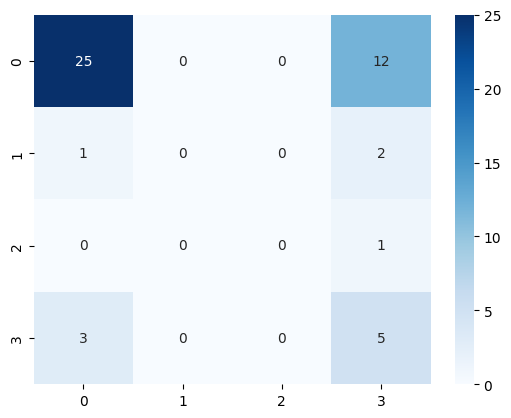

In [34]:
get_model_performance("/content/singlatask_noupsampling_val.csv")

# Inference on unseen data

In [35]:
test_data = pd.read_csv("/content/unlabelled_df.csv").astype(str)


In [36]:
test_data.head(1)

,submission_id,submission_title,submission_selftext,submission_link_flair_text,reply_body,all_text
0,aglcrj,Goodnotes 4 vs. Goodnotes 5 right now,I have used Goodnotes 4 for work a ton. And I...,nan,"[""I'm getting a ton of bugs with 5 as well (sn...",Goodnotes 4 vs. Goodnotes 5 right now I have u...


In [37]:
all_string = ("tag classification: " + test_data["all_text"]).to_list()

In [38]:
single_val = all_string[5]

In [39]:

tokenizer = T5Tokenizer.from_pretrained("/content/outputs/best_model")
model = T5ForConditionalGeneration.from_pretrained("/content/outputs/best_model")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [40]:
all_predictions = []

for i in range(len(all_string)):
  input_batch = tokenizer(all_string[i],
            padding=True,
            truncation=True,
            return_tensors='pt',
            max_length=400)
  input_ids = input_batch["input_ids"]
  attention_mask = input_batch["attention_mask"]

  # Use the model to make prediction
  prediction = model.generate(input_ids=input_ids,
              attention_mask=attention_mask,
              num_beams=4,
              max_length=300,
              do_sample=True,
              top_k=50,
              top_p=0.95,
              num_return_sequences=1)
  # To decode a sequence
  pred = tokenizer.decode(prediction[0], skip_special_tokens=True)
  # print(pred)
  all_predictions.append(pred)

# Add prediction to unlabelled data and convert it into csv


In [41]:
test_data["predicted_tags"] = all_predictions

In [42]:
test_data.to_csv("/content/unlabelled_data_with_predicted_tags.csv", index = False)

In [43]:
unlabelled_data_with_predicted_tags = pd.read_csv("/content/unlabelled_data_with_predicted_tags.csv")
unlabelled_data_with_predicted_tags.head()

,submission_id,submission_title,submission_selftext,submission_link_flair_text,reply_body,all_text,predicted_tags
0,aglcrj,Goodnotes 4 vs. Goodnotes 5 right now,I have used Goodnotes 4 for work a ton. And I...,NaN,"[""I'm getting a ton of bugs with 5 as well (sn...",Goodnotes 4 vs. Goodnotes 5 right now I have u...,Question
1,agoowm,The bundle is available !,NaN,NaN,['Thank you. I have been waiting!\n\n&amp;#x20...,NaN,Templates
2,agpzxb,What happened to the pen (Goodnotes 5)?,I just got Goodnotes 5 and I was so excited fo...,NaN,"[""Have you tried the ball pen? That was the cl...",What happened to the pen (Goodnotes 5)? I just...,Question
3,agq8qv,Non Apple Pencil styluses on GOodnotes 5?,I've been using a Wacom Bamboo stylus with Goo...,NaN,['According to the [review at Macstories](http...,Non Apple Pencil styluses on GOodnotes 5? I've...,Question
4,agqksi,Text/typing in Goodnotes 5,"Notability user here, but trying out Goodnotes...",NaN,"[""That's neat af"", 'Seattle, hopefully not too...",Text/typing in Goodnotes 5 Notability user her...,Question


# Convert model folder into zip for downloading

In [44]:
!zip -r /content/finetuned_model_files.zip /content/outputs


  adding: content/outputs/ (stored 0%)
  adding: content/outputs/best_model/ (stored 0%)
  adding: content/outputs/best_model/config.json (deflated 63%)
  adding: content/outputs/best_model/generation_config.json (deflated 29%)
  adding: content/outputs/best_model/eval_results.txt (stored 0%)
  adding: content/outputs/best_model/model.safetensors (deflated 7%)
  adding: content/outputs/best_model/added_tokens.json (deflated 83%)
  adding: content/outputs/best_model/spiece.model (deflated 48%)
  adding: content/outputs/best_model/tokenizer_config.json (deflated 95%)
  adding: content/outputs/best_model/model_args.json (deflated 63%)
  adding: content/outputs/best_model/scheduler.pt (deflated 55%)
  adding: content/outputs/best_model/special_tokens_map.json (deflated 85%)
  adding: content/outputs/best_model/optimizer.pt (deflated 14%)
  adding: content/outputs/best_model/training_args.bin (deflated 52%)
